In [1]:
# Copyright 2018 Esref Ozdemir
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Feature Analysis for Automatic Event Detection

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import pandas as pd

from utils import read_feature_csv

pd.options.display.float_format = '{:.5f}'.format 
pd.options.display.max_columns = None
# pandas 0.20 feature for much faster DataFrame computations
# bottleneck and numexpr libraries should be installed via pip
# They aren't essential, comment out if you don't want them.
pd.set_option('compute.use_bottleneck', True)
pd.set_option('compute.use_numexpr', True)

In [5]:
match_id = 20077

feature_df = pd.read_csv('../data/feature/{}_feature.csv'.format(match_id))
event_df = pd.read_csv('../data/event/{}_event.csv'.format(match_id))

display(feature_df.tail())
display(event_df.tail())

,half,minute,second,awayAvgX,awayAvgY,awayConvexCenterX,awayConvexCenterY,awayConvexClosestDistance,awayConvexFarDistance,awayConvexMaxSpeed,awayConvexMaxX,awayConvexMaxY,awayConvexMinX,awayConvexMinY,awayDenseClusterDensity,awayInnerDistance,awayMaxX,awayMaxY,awayMinX,awayMinY,awaySparseClusterDensity,homeAvgX,homeAvgY,homeConvexCenterX,homeConvexCenterY,homeConvexClosestDistance,homeConvexFarDistance,homeConvexMaxSpeed,homeConvexMaxX,homeConvexMaxY,homeConvexMinX,homeConvexMinY,homeDenseClusterDensity,homeInnerDistance,homeMaxX,homeMaxY,homeMinX,homeMinY,homeSparseClusterDensity,maxClusterImpurity,playerConvexCenterX,playerConvexCenterY,playerConvexClosestDistance,playerConvexFarDistance,playerConvexMaxSpeed,playerConvexMaxX,playerConvexMaxY,playerConvexMinX,playerConvexMinY,playerDenseClusterDensity,playerSparseClusterDensity,refSpeed,refX,refY
5543,2,90,43,61.54900,32.22700,60.28333,35.96000,11.91872,28.77116,1.70742,74.09000,64.62000,50.77000,16.26000,0.62239,928.91459,74.09000,64.62000,50.77000,16.26000,0.20550,57.76500,31.15800,57.75833,33.10167,11.72313,21.54573,2.05409,72.84000,51.51000,46.82000,16.76000,0.38937,879.74571,72.84000,51.51000,46.82000,16.76000,0.25534,0.50000,59.42750,30.88000,12.19686,33.90913,2.05409,74.09000,64.62000,46.82000,16.26000,0.92967,0.35176,1.19670,61.59000,45.65000
5544,2,90,44,60.56400,32.36700,59.33833,36.02000,10.84361,29.46292,1.67869,73.08000,65.41000,50.20000,16.40000,0.46747,911.66594,73.08000,65.41000,50.20000,16.40000,0.00000,56.37500,30.63500,56.52000,32.80333,12.04755,20.92676,2.23027,71.80000,51.14000,46.07000,16.46000,0.39119,870.10039,71.80000,51.14000,46.07000,16.46000,0.25546,0.50000,58.13000,30.81625,11.91035,34.74890,2.23027,73.08000,65.41000,46.07000,16.40000,0.97301,0.33008,0.70257,60.89000,45.59000
5545,2,90,45,58.36455,29.51545,58.26800,33.47800,13.54545,35.63132,1.68107,72.06000,66.37000,44.25000,0.72000,0.34814,1266.78335,72.06000,66.37000,44.25000,0.72000,0.00000,55.53300,30.59100,55.54833,32.65333,13.03572,20.19415,1.88799,70.79000,50.10000,45.19000,17.06000,0.35007,857.88392,70.79000,50.10000,45.19000,17.06000,0.24116,0.50000,57.98200,33.10800,15.17949,35.17883,1.68107,72.06000,66.37000,44.25000,0.72000,0.58954,0.31090,0.04123,60.90000,45.63000
5546,2,90,46,57.91364,30.05545,57.78800,33.79000,12.88955,35.28524,1.57410,70.89000,67.30000,44.78000,0.99000,0.35084,1246.35579,70.89000,67.30000,44.78000,0.99000,0.00000,55.27900,30.87800,59.16333,33.35333,12.14683,17.81676,1.52594,70.07000,48.83000,45.15000,17.56000,0.36317,841.28166,70.07000,48.83000,45.15000,17.56000,0.23594,0.50000,59.41667,32.55667,11.52663,34.79492,1.57410,70.89000,67.30000,44.78000,0.99000,0.59351,0.30000,0.05385,60.92000,45.68000
5547,2,90,47,58.84556,30.03556,57.90600,31.28800,6.73589,16.33153,1.80314,69.22000,43.75000,49.09000,16.98000,0.51906,527.81625,69.22000,43.75000,49.09000,16.98000,0.00000,54.54455,28.47727,57.34000,28.90714,12.32164,29.74353,1.49251,70.26000,47.57000,45.42000,1.57000,0.33984,1140.32197,70.26000,47.57000,45.42000,1.57000,0.24592,0.49383,58.39500,27.41625,11.12356,28.83105,1.49251,70.26000,47.57000,45.42000,1.57000,0.44996,0.44042,0.15033,60.77000,45.67000


,teamId,eventId,jersey,half,minute,second,location,bodyPart,postLocation,custom
1642,82,2,19,2,90,8,-1,-1,-1,-1
1643,82,2,21,2,90,11,-1,-1,-1,-1
1644,82,2,77,2,90,17,-1,-1,-1,-1
1645,82,72,77,2,90,23,1,3,-1,1
1646,82,97,77,2,90,29,-1,-1,-1,-1


## Introduction
In this document we will be analyzing various features obtained from players' $(x, y)$ coordinates via visualizations to see which features may be useful in automatically predicting events in a match.

Some example events that we are interested in are
1. Foul, Freekick, corner, throw-in, penalty, $\dots$
2. Attack, counter-attack, $\dots$
3. Goal, offside, $\dots$

We need to extract these events by observing how the features of interest evolves with time; thus, we can categorize our aim as a time series analysis task. Furthermore, if our predictions are to be used in real-time, we should be able to predict them in a time frame of 2-3 seconds before the event to 2-3 seconds after, at the latest.

In addition, we may use certain events that are easier to infer as prerequisites for other, more complex events. Attack may be prerequisite events for corners, offsides, penalties, etc. This may make the event prediction system more robust.

Some example data with the features we will analyze are as follows:

In [6]:
feature_df.head(5)

,half,minute,second,awayAvgX,awayAvgY,awayConvexCenterX,awayConvexCenterY,awayConvexClosestDistance,awayConvexFarDistance,awayConvexMaxSpeed,awayConvexMaxX,awayConvexMaxY,awayConvexMinX,awayConvexMinY,awayDenseClusterDensity,awayInnerDistance,awayMaxX,awayMaxY,awayMinX,awayMinY,awaySparseClusterDensity,homeAvgX,homeAvgY,homeConvexCenterX,homeConvexCenterY,homeConvexClosestDistance,homeConvexFarDistance,homeConvexMaxSpeed,homeConvexMaxX,homeConvexMaxY,homeConvexMinX,homeConvexMinY,homeDenseClusterDensity,homeInnerDistance,homeMaxX,homeMaxY,homeMinX,homeMinY,homeSparseClusterDensity,maxClusterImpurity,playerConvexCenterX,playerConvexCenterY,playerConvexClosestDistance,playerConvexFarDistance,playerConvexMaxSpeed,playerConvexMaxX,playerConvexMaxY,playerConvexMinX,playerConvexMinY,playerDenseClusterDensity,playerSparseClusterDensity,refSpeed,refX,refY
0,1,0,0,63.13300,34.34900,63.04571,34.22143,10.99570,26.98803,-1.00000,78.46000,61.20000,52.06000,8.07000,0.38821,1142.16103,78.46000,61.20000,52.06000,8.07000,0.36252,44.43300,32.87900,44.34250,33.21500,9.63489,24.81993,-1.00000,52.69000,53.50000,34.03000,9.67000,0.39964,912.89906,52.69000,53.50000,34.03000,9.67000,0.35267,0.50000,53.62000,33.22000,18.50352,29.76071,-1.00000,78.46000,61.20000,34.03000,8.07000,0.48728,0.34548,-1.00000,55.67000,26.23000
1,1,0,1,63.10800,34.30200,63.03286,34.16429,11.09222,27.03747,1.92094,78.56000,61.19000,51.95000,7.95000,0.38781,1145.52056,78.56000,61.19000,51.95000,7.95000,0.36706,44.55200,32.88900,44.45250,33.25000,9.42386,24.75514,3.86005,52.85000,53.39000,33.98000,9.78000,0.40117,911.43501,52.85000,53.39000,33.98000,9.78000,0.34736,0.50000,53.66250,33.21250,18.27631,29.76774,3.18277,78.56000,61.19000,33.98000,7.95000,0.50065,0.33784,1.34164,55.55000,26.29000
2,1,0,2,62.16100,33.96400,62.39000,33.83571,12.69954,28.20855,2.35968,79.60000,62.01000,49.71000,7.00000,0.42342,1203.40689,79.60000,62.01000,49.71000,7.00000,0.36082,46.67300,32.83700,47.68143,32.98429,10.49651,24.34361,4.85433,57.38000,53.35000,35.35000,10.39000,0.40870,904.49729,57.38000,53.35000,35.35000,10.39000,0.30344,0.50000,56.73571,32.78714,21.96407,30.05990,2.35968,79.60000,62.01000,35.35000,7.00000,0.48103,0.33591,1.47733,54.20000,26.89000
3,1,0,3,60.84900,33.71700,61.57000,33.59000,14.28013,29.87112,2.57847,80.21000,63.38000,47.29000,6.83000,0.28934,1268.33731,80.21000,63.38000,47.29000,6.83000,0.23488,49.62900,31.62600,49.46167,30.48667,11.32871,22.87770,6.07000,63.45000,52.62000,38.67000,8.88000,0.40875,932.62163,63.45000,52.62000,38.67000,8.88000,0.28137,0.50000,57.89143,32.46000,19.97097,31.47386,4.33171,80.21000,63.38000,38.67000,6.83000,0.49001,0.32663,2.00250,52.66000,28.17000
4,1,0,4,59.41400,32.83700,60.51429,32.85000,15.43469,31.80373,4.23967,80.64000,64.43000,45.37000,5.38000,0.28580,1309.69169,80.64000,64.43000,45.37000,5.38000,0.21439,52.57800,30.02100,54.04714,30.40286,12.67555,22.49000,7.50787,69.70000,52.09000,41.06000,9.36000,0.38920,975.45288,69.70000,52.09000,41.06000,9.36000,0.25594,0.50000,58.78000,32.05857,18.91221,32.83534,3.46342,80.64000,64.43000,41.06000,5.38000,0.53925,0.31931,1.32925,51.53000,27.47000


If we assume that majority of the match has **the same structure** in a **predefined set of features**, then we can find outliers to predict some events. We extend these definitions:

1. **The same structure:** We may assume that in majority of the match, average position of all players are close to the middle of the pitch. (Maybe a multivariate Gaussian with a diagonal covariance matrix). Then, outliers according to this model may indicate attacks, and specific events related to attacks such as corners, freekicks, penalties, etc.
2. **Predefined set of features:** Average position of all players is a combination of two of the features we have. We may find relations between other feature(s), or set of features, and events. Examples may be
  * Referee having close to $0$ speed for several seconds indicating free-kicks, etc.
  * Very high speeds by multiple players from both teams indicating a counter-attack or a key position.

## Ideas and Notes on How to Detect Certain Events
Notes about how to detect events and event characteristics.

* Italic terms are to be defined numerically.

### 1. Corner
* One player waiting at the corner kick spot for _some time_ with _low speed_.
* Fairly _steady positions_ and _low speeds_ **into** sprint or HIR or _high acceleration_ for a _short period_.
* Can be done rule based?

### 2. Free Kick
* One (or two, three) player(s) waiting _close_ and _steady_.
* Other players are not breaking the _structure_, they move within the structure.
* Fairly _steady positions_ and _low speeds_ **into** sprint or HIR or _high acceleration_ for a _short period_.
* Can be done rule based?

### 3. Not Getting Data For A Player

#### i. For a _Short Period_
* Cannot go too far. Use previous position?
* Can infer throw-ins if a player gets lost and comes back within a _short period_ of time.

#### ii. For a _Long Period_
* Injury? Maybe he is getting treatment.

### 4. Goal

#### i. Goal Celebration
* Goal scoring team has _very low_ convex area and player-to-player distance for a _long period_ of time.
* After goal celebration, both teams meet in the middle in full formation.
* Not always the mentioned pattern.

### 5. Player Change
* From either one of the teams, one player goes off, a new player comes in.

## Histograms About Various Features
We plot histograms about some features to have a general idea about the data we have.

### Average Player Position
Average player position is concentrated on the middle of the pitch, as expected. Very high or very low average player position may indicate attacks and events related to attacks, such as corners, freekicks, etc.

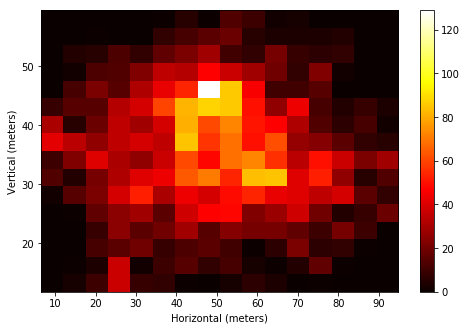

In [11]:
width = 8
plt.figure(figsize=(width, width*(68/105)))  # 105mx68m football pitch
plt.hist2d(feature_df['homeAvgX'], feature_df['homeAvgY'], cmap='hot', bins=16)

plt.xlabel('Horizontal (meters)')
plt.ylabel('Vertical (meters)')
plt.colorbar();

### Spread in $x$ and $y$
Spread in $y$ is much more uniform than spread in $x$, which is very concentrated around specific values. Outliers in these statistics may prove useful in predicting events related to team spread in $x$ or $y$.

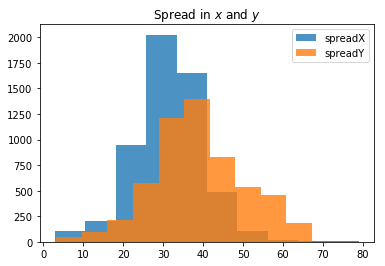

In [12]:
spreadX = feature_df['homeMaxX'] - feature_df['homeMinX']
spreadY = feature_df['homeMaxY'] - feature_df['homeMinY']
plt.hist(spreadX, label='spreadX', alpha=0.8)
plt.hist(spreadY, label='spreadY', alpha=0.8)
plt.legend()
plt.title('Spread in $x$ and $y$');

### Maximum $x$ and $y$
Viewing histograms of maximum and minimum $x$ and $y$ values can give us an idea about the general positional structure in the match.

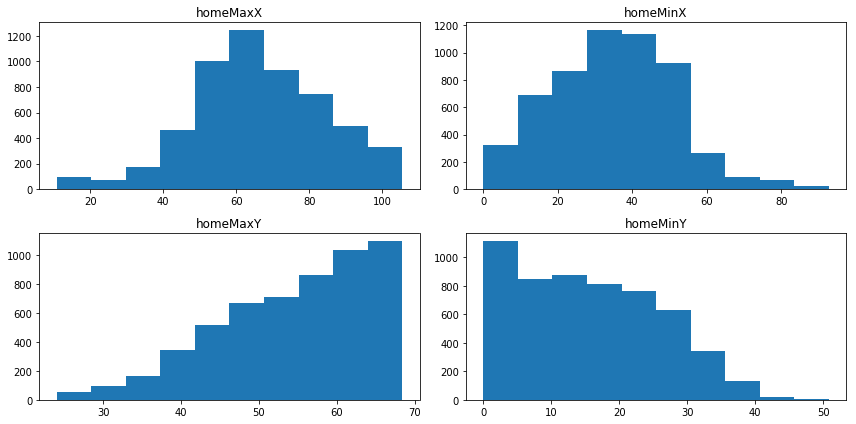

In [13]:
plt.figure(figsize=(12, 6))
cols = ['homeMaxX', 'homeMinX', 'homeMaxY', 'homeMinY']
num_c = len(cols)
for i in range(num_c):
    plt.subplot(num_c//2, num_c//2, i + 1)
    plt.hist(feature_df[cols[i]])
    plt.title(cols[i])
plt.tight_layout()

The distributions of **playerMaxY** and **playerMinY** may indicate that the vertical distance between the top and the bottom player does not change significantly; teams tend to keep their vertical structure.

## Time Analysis of Various Features
We try to find patterns in some features that may indicate certain events of interest.

### Team Inner Distance
Distance sum of players in a team is stored in two features, **homeInnerDistance** and **awayInnerDistance**, and calculated as:

$$D_{team_i} = \sum_{j=0}^{10}\sum_{k=j+1}^{10} dist(j, k).$$

Significant decreases in inner distance may indicate some events. One such example is goal celebration:

Minutes that have inner distance less than 400: [15 16 22 23 24 25 35 36 37 43 50 63 81 87]
Goal minutes: [23 25 62 80 87]


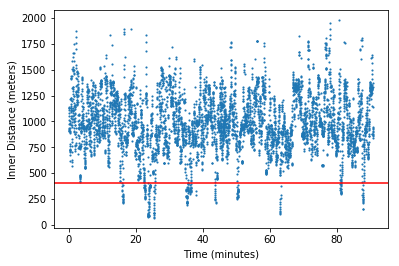

In [15]:
# get goal minutes
goal_event_ids = [80, 96]
goal_event_mask = np.in1d(event_df['eventId'].values, goal_event_ids)
goal_events = event_df[goal_event_mask]
goal_mins = (goal_events['minute'] + goal_events['second']/60).values

# feature data
dist = feature_df['homeInnerDistance']
mins = feature_df['minute'] + feature_df['second']/60

threshold = 400

# plot minutes vs. distance
plt.plot(mins, dist, '.', markersize='2.25')

# horizontal line to see easier
plt.axhline(threshold, color='red')

plt.xlabel('Time (minutes)')
plt.ylabel('Inner Distance (meters)')

print('Minutes that have inner distance less than {}: {}'
      .format(threshold, np.unique(mins[dist < threshold].astype(int))))
print('Goal minutes: {}'.format(goal_mins.astype(int)))

Yet, this statistic is not indicative of goals by itself.

Unique minutes that have inner distance less than 400: [ 3 17 35 37 44 58 59]
Goal minutes: [23 25 62 80 87]


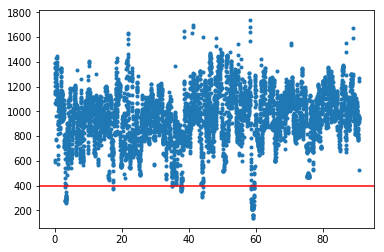

In [16]:
dist = feature_df['awayInnerDistance']
plt.plot(mins, dist, '.');
plt.axhline(threshold, color='red')
print('Unique minutes that have inner distance less than {}: {}'\
      .format(threshold, np.unique(mins[dist < threshold].astype(int))))
print('Goal minutes: {}'.format(goal_mins.astype(int)))

#### Difference of Inner Distances
Difference of inner distance sums can be used in predicting which team has ball possession, and specifically which team is on the attack. Teams that has the ball generally have higher inner distance sum since they tend to
1. have players on top and bottom wings away from the other players
2. have attacking players close to opponent's goalpost while their defence players waiting close to the middle of the pitch

Below we compare the difference of inner distances and actual **hasBall** event data. Positive event data means home team has the ball. Thus, we expect the signs of event data and inner distance differences to be the same.

In [53]:
# get home team id
hasball_df = pd.read_csv('../data/hasball/{}_hasball.csv'.format(match_id))
home_id = (hasball_df[hasball_df['teamPoss'] == 1]['hasballTeam'].values[0])

# hasball events
hb_df = event_df.loc[event_df['eventId'] == 2].copy()

# combine minutes and seconds to floats
hb_df['minute'] += hb_df['second']/60
hb_df = hb_df[['teamId', 'minute']]
hb_df.reset_index(drop=True, inplace=True)

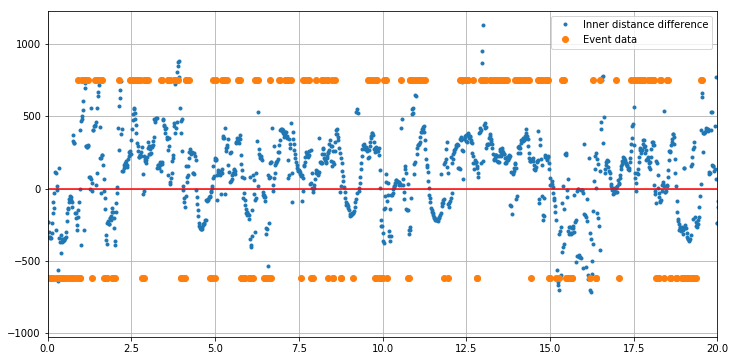

In [54]:
teamId, minute = hb_df.values.T  # get underlying columns as np arrays
inner_diff = feature_df['homeInnerDistance'] - feature_df['awayInnerDistance']
max_diff = np.percentile(inner_diff, 99)
min_diff = np.percentile(inner_diff, 1)
# set team ids to found percentiles for visualization
teamId[teamId == home_id] = max_diff
teamId[teamId != max_diff] = min_diff
# plot
plt.figure(figsize=(12, 6))
plt.xlim([0, 20])
plt.plot(mins, inner_diff, '.', label='Inner distance difference')
plt.plot(minute, teamId, 'o', label='Event data')
plt.axhline(0, color='r')
plt.grid()
plt.legend();

### Maximum and Minimum $x$

#### Thresholding
Significantly low **maximum $x$** values may indicate an attack, specifically corner kicks or throw-ins very close to the outline, by one team whereas significantly high **minimum $x$** values may indicate an attack by the other.

Below we see playerMaxX and playerMinX values.

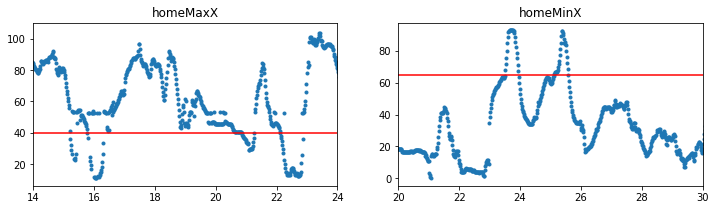

In [55]:
attack_threshold = 40
plt.figure(figsize=(12, 3))
cols = {
        'homeMaxX' : ([14, 24], attack_threshold),
        'homeMinX' : ([20, 30], 105 - attack_threshold),
       }
i = 1
for col, (lim, threshold) in cols.items():
    plt.subplot(1, 2, i)
    plt.xlim(lim)  # limits to zoom in
    plt.title(col)
    plt.plot(mins, feature_df[col], '.')
    plt.axhline(threshold, color='red');
    i += 1

#### Differential
Significant decreases or increases on playerMaxX or playerMinX may indicate counter attacks or very fast-developing attacks and key positions.

In [56]:
def plot_differential(mins, cols, *args, dt=1, **kwargs):
    '''
    Plot the differentials of the columns of a pandas DataFrame or Series.
    Data points should be one second apart.
    
    Parameters
    ----------
    cols: pandas DataFrame or Series object containing arrays in its columns
          whose differentials will be plotted.
          
    *args: Forwarded to matplotlib.pyplot.plot
    
    dt: Time interval between two data points in the differential, in seconds.
        Must be a positive integer.
    
    **kwargs: Forwarded to matplotlib.pyplot.plot
    '''
    cols = pd.DataFrame(cols)
    not_int = dt != int(dt)
    if not_int or dt <= 0:
        raise ValueError('dt must be a positive integer')
    for cname in cols:
        arr = cols[cname].values
        differential = (arr[dt::dt] - arr[0:-dt:dt])
        time_scale = mins[dt::dt]
        plt.plot(time_scale, differential, *args, **kwargs, label=cname)
    plt.legend();

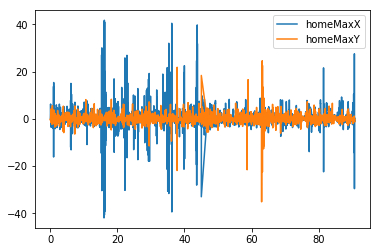

In [57]:
plot_differential(mins, feature_df[['homeMaxX', 'homeMaxY']], dt=1)

### Referee Position for Penalty Detection
Referee position, more so the $x$ coordinate, can be used for penalty detection. Referees tend to not stay in their position predetermined "penalty position" for _prolonged periods_.

Referee position may also be combined with referee speed.

Penalty at 25


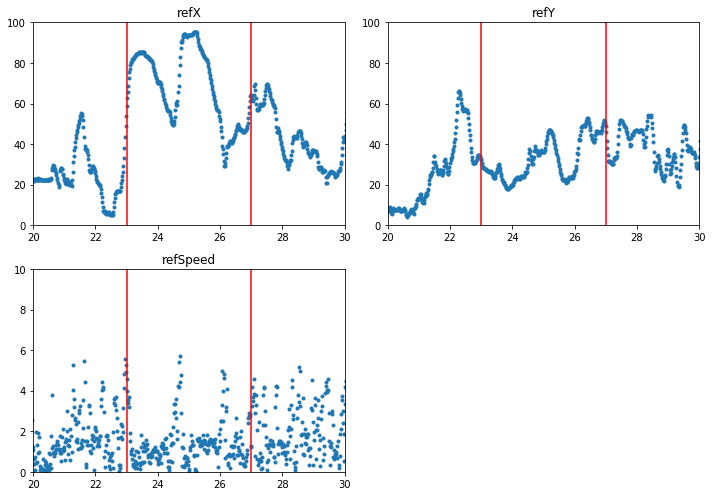

In [63]:
penalty_events = event_df[event_df['eventId'] == 93]
if penalty_events.empty:
    print('No penalty event in this match')
else:
    penalty_min = int(penalty_events['minute'].iloc[0])
    print('Penalty at {}'.format(penalty_min))
    max_min = feature_df['minute'].max()
    cols = {
            'refX' :    [0, 100],
            'refY' :    [0, 100],
            'refSpeed': [0, 10],
            }
    plt.figure(figsize=(10, 7))
    i = 1
    for col, lim in cols.items():
        plt.subplot(2, 2, i)
        plt.title(col)
        plt.xlim([max(penalty_min - 5, 0), min(penalty_min + 5, max_min)])
        plt.ylim(lim) 
        plt.plot(mins, feature_df[col], '.')
        plt.axvline(penalty_min - 2, color='red')
        plt.axvline(penalty_min + 2, color='red')
        i += 1
    plt.tight_layout()

### convexFarDistance
Low **convexFarDistance** values can be used to determine when the players pack together and the whole game is played on a very small area. This may in turn be useful in predicting 
1. important fouls
2. goal kicks

However, low **convexFarDistance** value may also point to parts of the game where both teams are trying keep hold of the ball in the middle of the pitch and not many important events happening. Thus, it may not be an indicative feature by itself.

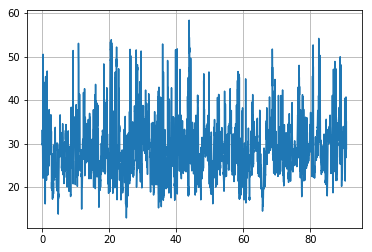

In [64]:
plt.plot(mins, feature_df['playerConvexFarDistance']);
plt.grid();

### convexClosestDistance

#### Using Along with convexFarDistance
We can check where $convexFarDistance + convexClosestDistance$ takes low values to see where both **convexFarDistance** and **convexClosestDistance** takes low values. This may allow us to identify parts where
* furthest player is close to the convex center
* closest player is very close to the convex center

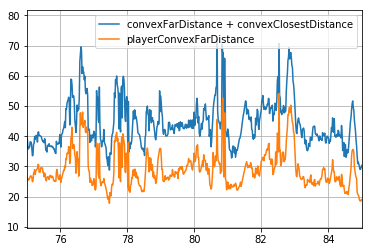

In [65]:
plt.plot(
    mins,
    feature_df['playerConvexFarDistance'] + feature_df['playerConvexClosestDistance'],
    label='convexFarDistance + convexClosestDistance'
)
plt.plot(mins, feature_df['playerConvexFarDistance'])
plt.legend()
plt.grid()
plt.xlim([75, 85]);

### convexMaxSpeed
_Prolonged_ periods of _very low_ **convexMaxSpeed** may indicate events that stops the game or events that happens after a game stop such as

1. out, goal kick
2. foul
3. freekick, penalty, corner, etc.
4. player switching

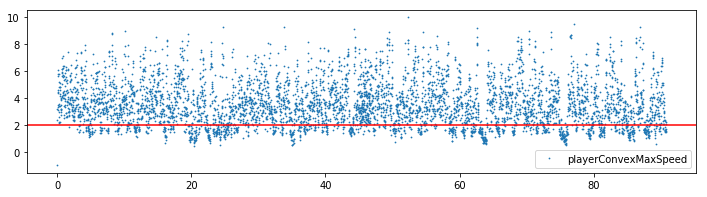

In [67]:
plt.figure(figsize=(12, 3))
plt.plot(mins, feature_df['playerConvexMaxSpeed'], '.', markersize='1.5')
plt.axhline(2, color='r');
plt.legend();